## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
# Summarize dataset 
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


From the table above, some variables have mean value in the thousands while others has value in less than 1. This means we should scale feature.

Note: I was debating whether to assign features before or after data split with consideration of information leakage but decided to follow instructions strictly. 

In [3]:
# Assign target variable
y = df['Cover_Type']
# Assign features
X = df.drop(columns='Cover_Type')

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 808)

# Create scaler 
scaler = StandardScaler()
# Scale features in train and test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

Note: `StratifiedKFold` ensures that each fold maintains the same percentage of samples for each class as the original dataset. This is particularly useful for imbalanced datasets

In [4]:
# Initialize cross validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=808)

# Construct param grid
param_grid = {
    'C':[0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
# Create model
svc_md = SVC(random_state=808)

# Grid search
gs_svc = GridSearchCV(svc_md, param_grid, cv = cv, scoring='accuracy', n_jobs=5)

In [5]:
# Get initial time
start_time = time.time()

# Fit model
gs_svc.fit(X_train_scaled, y_train)

# Get time training model
end_time = time.time()
elapsed_time_svm = end_time - start_time

# Retrieve best params
best_params = gs_svc.best_params_

# Print result
print(f"Best parameters: {best_params}")
print(f"Computational time: {elapsed_time_svm} seconds")

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Computational time: 1225.5124206542969 seconds


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [8]:
# RF Parameter grid
rf_param_grid = {
    'n_estimators': [10, 50, 100, 2000],
    'max_depth': [2, 5, 10, None],
    'max_features': ['sqrt', 'log2', None]}

# Initialize RF model
rf_md = RandomForestClassifier(random_state=808)

# Gridsearch for best params
gs_rf = GridSearchCV(estimator=rf_md, param_grid=rf_param_grid, cv=cv, scoring='accuracy', n_jobs=16)


In [9]:
# Get time
start_time_rf = time.time()

# Fit model
gs_rf.fit(X_train_scaled, y_train)

# get end tine 
end_time_rf = time.time()

# Calculate elapsed time
elapsed_time_rf = end_time_rf - start_time_rf

/opt/python/3.7.13/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [10]:
# Print results
print(f"Best parameters: {gs_rf.best_params_}")
print(f"Computational time: {elapsed_time_rf:2f} seconds")

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 2000}
Computational time: 139.345785 seconds


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [11]:
# Initialize best SVM and RF models
best_svm = SVC(C=100, gamma='scale', kernel='rbf', random_state=808)
best_rf = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=2000, random_state=808)

# Fit models
best_svm.fit(X_train_scaled, y_train)
best_rf.fit(X_train_scaled, y_train)

# Make predictions on models
svm_pred = best_svm.predict(X_test_scaled)
rf_pred = best_rf.predict(X_test_scaled)


Generate confusion matrix for each model

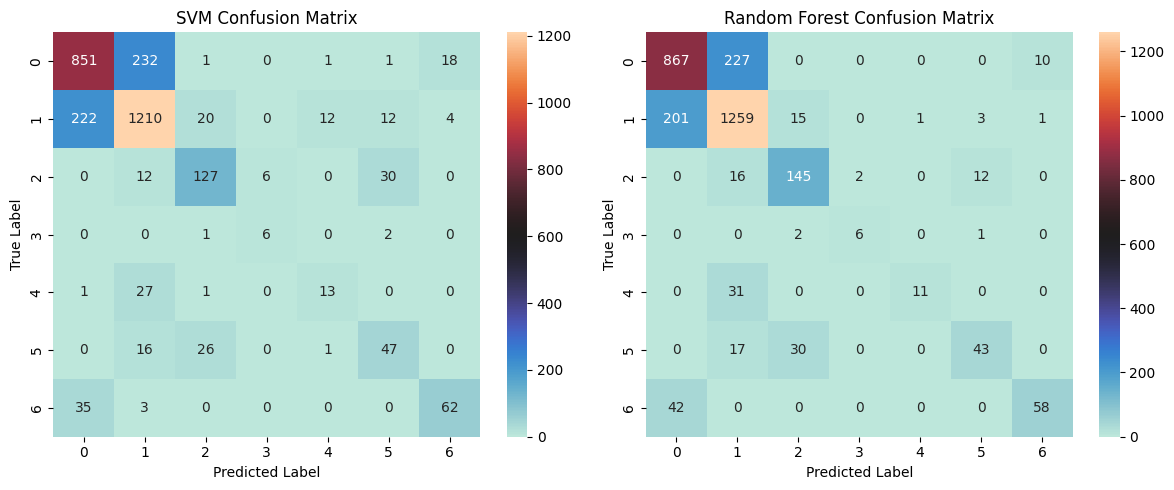

In [31]:
# Calculate metrics
cm_svm = confusion_matrix(y_test, svm_pred)
cm_rf = confusion_matrix(y_test, rf_pred)

#Plot svm cm 
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_svm, annot=True, fmt="d", cmap='icefire', ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")


# Plot rf cm
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='icefire', ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
plt.tight_layout()
plt.show()

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [21]:
acc_svm = accuracy_score(y_test, svm_pred)
acc_rf = accuracy_score(y_test, rf_pred)

print(f"SVM Accuracy: {acc_svm:.4f}, Runtime: {elapsed_time_svm:.1f} seconds")
print(f"RF Accuracy: {acc_rf:.4f}, Runtime: {elapsed_time_rf:.1f} seconds")

SVM Accuracy: 0.7720, Runtime: 1225.5 seconds
RF Accuracy: 0.7963, Runtime: 139.3 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


From the confusion matrix, Random Forest performs better overall, as it has higher correct predictions (on the diagonal) and fewer misclassifications in key areas. 

The SVM model achieved an overall accuracy of 77.2%, while the Random Forest model demonstrated an accuracy of 79.6%. In terms of training time, the SVM required 20 minutes, compared to 2 minutes for the Random Forest. 

Considering these metrics, the Random Forest model appears more more efficient and suitable for this specific task.